### Emergency room visit cost prediction
- Classification problem: where the patients are gonna end up from ED
- Predict ED costs

In [1]:
## import
import os
import pandas as pd
from pandas import DataFrame as df
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder
from sklearn.metrics import recall_score, precision_score, average_precision_score, roc_auc_score
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

from scipy.stats import sem
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

os.chdir('C:/Users/binh/Dropbox (CareSkore)/Customer_data/MEPS_expenditure prediction')

C:\Users\binh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# import NEDS
neds = pd.read_stata('C:/Users/binh/Dropbox (CareSkore)/Research Data/Nationwide_Emergency_Department_Sample/unzip/NEDS_core_v2.dta'
                     )

In [3]:
# shape and columns
print('neds shape: {}'.format(neds.shape))
print('neds columns: \n{}'.format(neds.columns))

neds shape: (295817, 100)
neds columns: 
Index(['age', 'amonth', 'aweekend', 'chron1', 'chron2', 'chron3', 'chron4',
       'chron5', 'chron6', 'chron7', 'chron8', 'chron9', 'chron10', 'chron11',
       'chron12', 'chron13', 'chron14', 'chron15', 'died_visit', 'discwt',
       'disp_ed', 'dqtr', 'dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7',
       'dx8', 'dx9', 'dx10', 'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'ecode1',
       'ecode2', 'ecode3', 'ecode4', 'edevent', 'e_ccs1', 'e_ccs2', 'e_ccs3',
       'e_ccs4', 'female', 'hcupfile', 'hosp_ed', 'injury', 'injury_cut',
       'injury_drown', 'injury_fall', 'injury_fire', 'injury_firearm',
       'injury_machinery', 'injury_mvt', 'injury_nature', 'injury_poison',
       'injury_severity', 'injury_struck', 'injury_suffocation',
       'intent_assault', 'intent_self_harm', 'intent_unintentional', 'key_ed',
       'multinjury', 'ndx', 'necode', 'neds_stratum', 'pay1', 'pay2',
       'pl_nchs', 'totchg_ed', 'year', 'zipinc_qrtl', 'hh_inc1'

In [4]:
# unique values / tabs
print('Month value counts: \n {}'.format(neds['amonth'].value_counts()))
print('Weekend value counts: \n {}'.format(neds['aweekend'].value_counts()))

Month value counts: 
 1.0     21935
7.0     21111
5.0     20849
3.0     20644
8.0     20643
9.0     20628
12.0    20524
4.0     20282
6.0     20232
10.0    20125
11.0    19190
2.0     18793
Name: amonth, dtype: int64
Weekend value counts: 
 0    212227
1     83590
Name: aweekend, dtype: int64


In [5]:
## unique values/ tabs
print ('ndx tab: {}'.format(neds['ndx'].value_counts()))

ndx tab: 1     80910
2     61036
3     39104
4     26131
5     17999
15    14998
6     13137
7      9627
8      7477
9      6560
10     5758
11     3831
12     3302
13     3042
14     2754
0       151
Name: ndx, dtype: int64


In [6]:
# Create buckets for classification
neds.loc[(neds['ed_routine']== 1), 'ed_group'] = 1
neds.loc[(neds['ed_transfer']==1), 'ed_group'] = 2
neds.loc[(neds['ed_inpatient']==1), 'ed_group'] = 3
neds.loc[(neds['ed_died'] ==1), 'ed_group'] = 4

In [7]:
# Create age buckets
neds.loc[(neds['age'] <= 17), 'age_group'] = 1
neds.loc[(neds['age'] > 17) & (neds['age'] <= 39), 'age_group'] = 2
neds.loc[(neds['age'] > 39) & (neds['age'] <= 64), 'age_group'] = 3
neds.loc[(neds['age'] >= 65), 'age_group'] = 4

In [8]:
neds['age_group'].value_counts()

2.0    97345
3.0    86611
1.0    58231
4.0    53618
Name: age_group, dtype: int64

In [9]:
neds['zipinc_qrtl'].value_counts()

1.0    101463
2.0     80286
3.0     63072
4.0     44567
Name: zipinc_qrtl, dtype: int64

In [10]:
neds['ed_group'].value_counts()

1.0    243884
3.0     42636
2.0      8442
4.0       441
Name: ed_group, dtype: int64

In [11]:
## sort values. Need to update the dataframe
neds = neds.sort_values(by=["zipinc_qrtl"], ascending=True)

In [12]:
### define training and testing data
target = 'ed_group'

features = ['age_50', 'age_64', 'age_74','female', 
            'medicare', 'medicaid', 'private', 'selfpay',
            'injury',  'multinjury' , 'ndx' , 'necode' , 
            'intent_self_harm', 'intent_unintentional', 'intent_assault', 'injury_drown', 'injury_fall', 'injury_fire', 
            'injury_firearm', 'injury_machinery', 'injury_mvt', 'injury_nature', 'injury_poison', 'injury_struck',     
           ] 

In [13]:
X = neds[features]
Y = neds[target]

# split the data
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size = 0.1, random_state=25)

In [14]:
def imp(XTrain, YTrain, XTest, YTest):
    imp = Imputer(missing_values = 'NaN', strategy="mean")
    XTrain_Imp = imp.fit_transform(XTrain)
    YTrain_Imp = imp.fit_transform(YTrain.reshape(-1, 1)).ravel().astype(int)
    XTest_Imp = imp.fit_transform(XTest)
    YTest_Imp = imp.fit_transform(YTest.reshape(-1, 1)).ravel().astype(int)
    return XTrain_Imp , YTrain_Imp, XTest_Imp, YTest_Imp

XTrain_Imp , YTrain_Imp, XTest_Imp, YTest_Imp = imp(XTrain, YTrain, XTest, YTest) 

C:\Users\binh\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\binh\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [15]:
## one hot encoder but nothing one hot encoder can do

### multi-output multiclass
There are multiple approaches for this problem

In [16]:
## multiclas learning using OvR
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
multi_class = OneVsRestClassifier(LinearSVC(random_state=0)).fit(XTrain_Imp, YTrain_Imp)
Y_pred_multi = multi_class.predict(XTest_Imp)

In [17]:
# import numpy
# numpy.set_printoptions(threshold=numpy.nan)
Y_pred_multi

array([1, 1, 1, ..., 1, 1, 1])

In [18]:
## evaluate classifier
from sklearn.metrics import f1_score
f1_score_macro = f1_score(YTest_Imp, Y_pred_multi, average='macro')  
print('f1_score macro method: {}'.format(f1_score_macro))

f1_score_micro = f1_score(YTest_Imp, Y_pred_multi, average='micro')  
print('f1_score micro method: {}'.format(f1_score_micro))

f1_score_weight = f1_score(YTest_Imp, Y_pred_multi, average='weighted')  
print('f1_score weight method: {}'.format(f1_score_weight))

f1_score macro method: 0.39265804771697727
f1_score micro method: 0.8828341559056183
f1_score weight method: 0.863946806909235


C:\Users\binh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
### evaluation: confusion matrix
from sklearn.metrics import confusion_matrix
y_test_hat = multi_class.predict(XTest_Imp)
ovr_matrix =confusion_matrix(YTest_Imp, y_test_hat),
ovr_matrix

(array([[23730,     1,   724,     0],
        [  701,     0,   142,     0],
        [ 1861,     0,  2386,     0],
        [   33,     0,     4,     0]]),)

In [24]:
## plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
# Compute confusion matrix
import numpy as np
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(ovr_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(ovr_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

Confusion matrix, without normalization
(array([[23730,     1,   724,     0],
       [  701,     0,   142,     0],
       [ 1861,     0,  2386,     0],
       [   33,     0,     4,     0]]),)


AttributeError: 'tuple' object has no attribute 'max'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000185AA09F048> (for post_execute):


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

In [73]:
##   Multioutput classification // can do multipclass regression when needd be
'''Multioutput classification support can be added to any classifier with MultiOutputClassifier. 
This strategy consists of fitting one classifier per target. This allows multiple target variable classifications. 
The purpose of this class is to extend estimators to be able to estimate a series of target functions (f1,f2,f3...,fn) 
that are trained on a single X predictor matrix to predict a series of reponses (y1,y2,y3...,yn).'''
from sklearn.multioutput import MultiOutputClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

In [ ]:
## not working ValueError: y must have at least two dimensions for multi target regression but has only one.
multi_target_forest.fit(XTrain_Imp, YTrain_Imp).predict(XTest_Imp)

In [83]:
# try another method --> working
multi_class_2 = OneVsRestClassifier(forest).fit(XTrain_Imp, YTrain_Imp)
Y_pred_multi_2 = multi_class_2.predict(XTest_Imp)

In [84]:
## evaluate classifier
from sklearn.metrics import f1_score
f1_score_macro = f1_score(YTest_Imp, Y_pred_multi_2, average='macro')  
print('f1_score macro method: {}'.format(f1_score_macro))

f1_score_micro = f1_score(YTest_Imp, Y_pred_multi_2, average='micro')  
print('f1_score micro method: {}'.format(f1_score_micro))

f1_score_weight = f1_score(YTest_Imp, Y_pred_multi_2, average='weighted')  
print('f1_score weight method: {}'.format(f1_score_weight))

f1_score macro method: 0.41258488421886597
f1_score micro method: 0.881955243053208
f1_score weight method: 0.8659840901539307


### Emergency Room cost estimation
- Do data exploratory analysis
- How to do combining models 

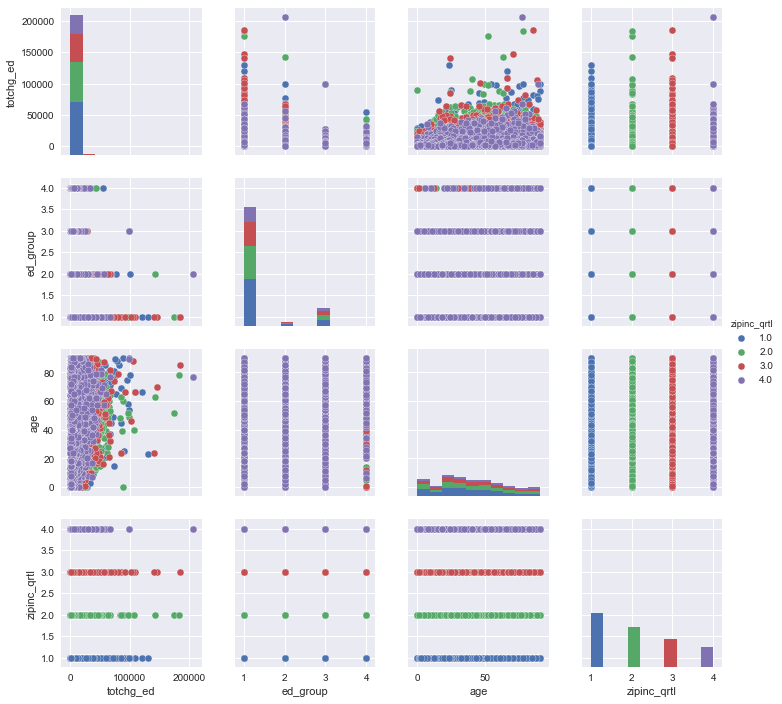

In [95]:
import seaborn as sns
sns.set()
select_cols= ['totchg_ed', 'ed_group', 'age', 'zipinc_qrtl']
sns.pairplot(neds[select_cols].dropna(),  hue="zipinc_qrtl")  ## dropna() to deal with missing values

### how to summarize a dataset (histogram, boxplot, mean, mode, median, std/variance, quantile)
#### exploratory data analysis, how to spot outliers

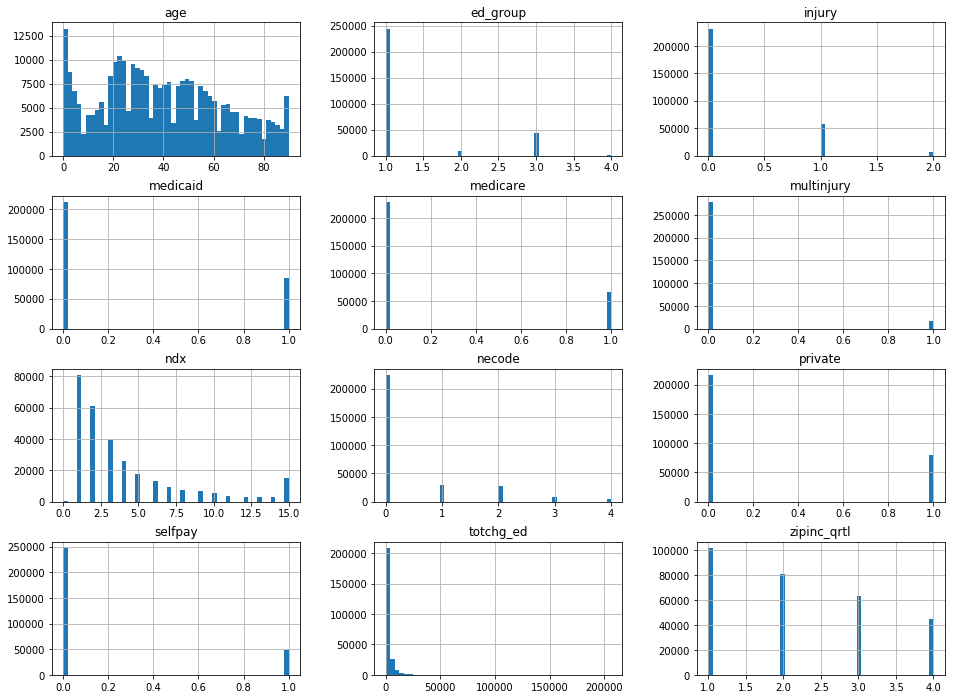

In [14]:
# histogram 
select_cols= ['totchg_ed', 'ed_group', 'age', 'zipinc_qrtl', 'medicare', 'medicaid', 'private', 'selfpay',
            'injury',  'multinjury' , 'ndx' , 'necode']

neds[select_cols].hist(figsize=(16,12),bins=50)
plt.show()

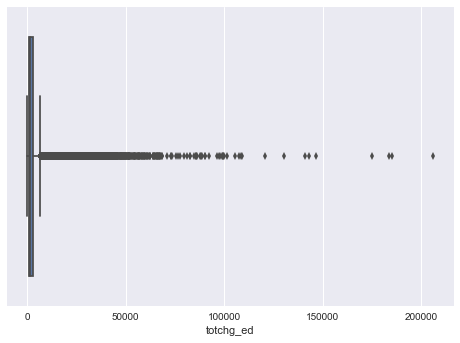

In [15]:
## boxplot
import seaborn as sns
sns.set_style()
ax = sns.boxplot(x=neds["totchg_ed"])

In [16]:
## delete outliers
neds = neds[neds['totchg_ed']<15000]

In [ ]:
## other boxplots -- please don't run this nexttime, very time consuming
ax = sns.boxplot(x="ndx", y="totchg_ed", orient="h", palette="Set2" , data=neds)

In [35]:
## count for missing data
## create a dataframe to report missing
neds.isnull().sum()

age                   6
amonth            48744
aweekend              0
chron1              143
chron2            67514
chron3           119017
chron4           152139
chron5           174319
chron6           189486
chron7           200431
chron8           208352
chron9           214387
chron10          219499
chron11          223866
chron12          226768
chron13          229260
chron14          231553
chron15          233632
died_visit          322
discwt                0
disp_ed               0
dqtr                158
dx1                   0
dx2                   0
dx3                   0
dx4                   0
dx5                   0
dx6                   0
dx7                   0
dx8                   0
                  ...  
pl_nchs            1632
totchg_ed             0
year                  0
zipinc_qrtl        5091
hh_inc1            5091
hh_inc2            5091
hh_inc3            5091
hh_inc4            5091
rich                  0
middle                0
poor            

In [24]:
# http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-21.html
neds.mean()                 # Get the mean of each column

age                 38.957271
amonth               6.476510
aweekend             0.282862
chron1               0.166967
chron2               0.369485
chron3               0.469556
chron4               0.519123
chron5               0.534522
chron6               0.539097
chron7               0.541914
chron8               0.536519
chron9               0.533371
chron10              0.533394
chron11              0.532639
chron12              0.523198
chron13              0.516859
chron14              0.492715
chron15              0.493933
died_visit           0.008392
discwt               4.607618
disp_ed              2.347332
dqtr                 2.494029
edevent              1.297126
e_ccs1            2586.905699
e_ccs2            2609.553402
e_ccs3            2610.295148
e_ccs4            2616.361186
female               0.558188
hosp_ed          24552.401729
injury               0.245857
                     ...     
pl_nchs              2.862941
totchg_ed         2331.394584
year      

In [95]:
## hypothesis testing and confidence interval
# http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-24.html

import numpy as np
import statsmodels as sms
from statsmodels.stats.weightstats import CompareMeans

X1, X2 = np.arange(10,21), np.arange(20,26.5,.5)

cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
print ('Compare means: {}'.format(cm.tconfint_diff(usevar='unequal')))

AttributeError: module 'statsmodels' has no attribute 'CompareMeans'

## note on SQL
- Write a query or set of queries to derive insights based on the given log(s) or schema(s)
- Work with aggregate functions
- Utilize different types of Joins (IE: Left, Inner, Outer, etc.)
- Utilize Union and Union All.
- Work with concepts including Distinct, Random Sampling, De-Duplication, Optimization.
- Apply the results of your analysis to make product decisions or suggestions.

### data analysis
    + check for data quality
    + data cleaning techniques (handling missing data, data normalization, removing outliers)
    + data plotting: how to plot/summarize
    + numerical data vs. categorical data
    + text data analysis
    + check for relationship/correlation between variables
    + data clustering

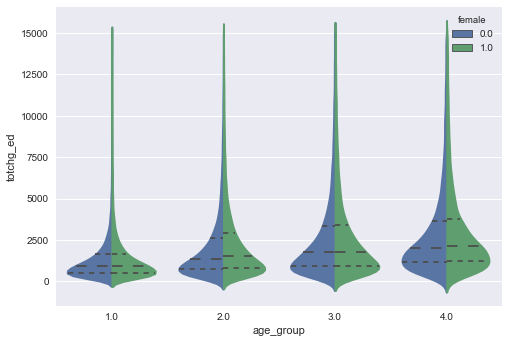

In [103]:
import seaborn as sns
sns.set()
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x="age_group", y="totchg_ed", hue="female", data=neds, split=True,
               inner="quart", )
sns.despine(left=True)

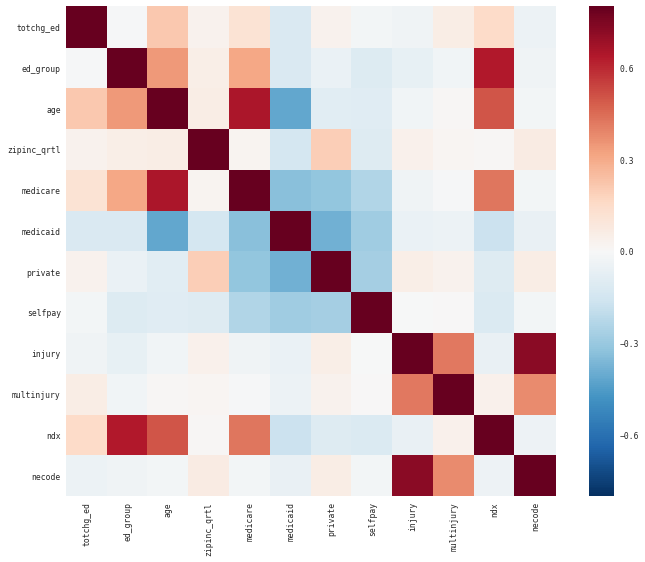

In [21]:
## check for relationship/correlation between variables
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context = "paper", font = "monospace")

# select a few columns with correlation
select_cols= ['totchg_ed', 'ed_group', 'age', 'zipinc_qrtl', 'medicare', 'medicaid', 'private', 'selfpay',
            'injury',  'multinjury' , 'ndx' , 'necode']

# Load the datset of correlations
corrmat = neds[select_cols].corr()

f, ax = plt.subplots(figsize = (12,9))
sns.heatmap(corrmat, vmax= 0.8, square = True)

In [22]:
corrmat

,totchg_ed,ed_group,age,zipinc_qrtl,medicare,medicaid,private,selfpay,injury,multinjury,ndx,necode
totchg_ed,1.000000,-0.006742,0.213625,0.036038,0.117625,-0.122531,0.036035,-0.019221,-0.035720,0.057288,0.155644,-0.044492
ed_group,-0.006742,1.000000,0.347739,0.056127,0.306460,-0.123798,-0.052750,-0.107318,-0.067704,-0.026797,0.642681,-0.035374
age,0.213625,0.347739,1.000000,0.061280,0.650111,-0.412910,-0.090094,-0.096274,-0.029920,0.011713,0.500597,-0.019484
zipinc_qrtl,0.036038,0.056127,0.061280,1.000000,0.023287,-0.138186,0.199284,-0.101780,0.041482,0.015414,0.009039,0.063366
medicare,0.117625,0.306460,0.650111,0.023287,1.000000,-0.335705,-0.318711,-0.238897,-0.035778,-0.009622,0.429762,-0.021838
medicaid,-0.122531,-0.123798,-0.412910,-0.138186,-0.335705,1.000000,-0.382444,-0.286670,-0.050820,-0.045581,-0.172541,-0.058231
private,0.036035,-0.052750,-0.090094,0.199284,-0.318711,-0.382444,1.000000,-0.272157,0.051775,0.034136,-0.100585,0.060804
selfpay,-0.019221,-0.107318,-0.096274,-0.101780,-0.238897,-0.286670,-0.272157,1.000000,-0.002898,0.001309,-0.117399,-0.020148
injury,-0.035720,-0.067704,-0.029920,0.041482,-0.035778,-0.050820,0.051775,-0.002898,1.000000,0.424354,-0.059215,0.719618
multinjury,0.057288,-0.026797,0.011713,0.015414,-0.009622,-0.045581,0.034136,0.001309,0.424354,1.000000,0.041175,0.379490


## modelling ED costs
- focus on using pipeline to combine models to have optimal results

#### dealling with categorical data -- not working
- converting the categorical data to label
- converting the labels to binary varibles (one-hot encoding)

'''my question: I dont know how to work with onehotencoder. Should it be a subset of data with categorical variable and then after
en we will convert/merge the data back to the big original data. Should it be an encoder for the whole data? '''


In [ ]:
### this code is not working
categorical_features = ['necode','ndx','zipinc_qrtl']
XTrain[categorical_features]
categorical_features = ['necode','ndx','zipinc_qrtl']

## label encoder
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()

lbl_enc.fit(XTrain_Imp[categorical_features])
xtrain_cat = lbl_enc.transform(XTrain_Imp[categorical_features])

## one hot encoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(XTrain_Imp[categorical_features])
xtrain_cat = ohe.transform(XTrain_Imp)

### Linear model to prepare for pipeline

In [40]:
# cost prediction
target = 'totchg_ed'

features = ['age_50', 'age_64', 'age_74','female', 
            'medicare', 'medicaid', 'private', 'selfpay',
            'injury',  'multinjury' , 'ndx' , 'necode' , 
            'intent_self_harm', 'intent_unintentional', 'intent_assault', 'injury_drown', 'injury_fall', 'injury_fire', 
            'injury_firearm', 'injury_machinery', 'injury_mvt', 'injury_nature', 'injury_poison', 'injury_struck',     
            ] 

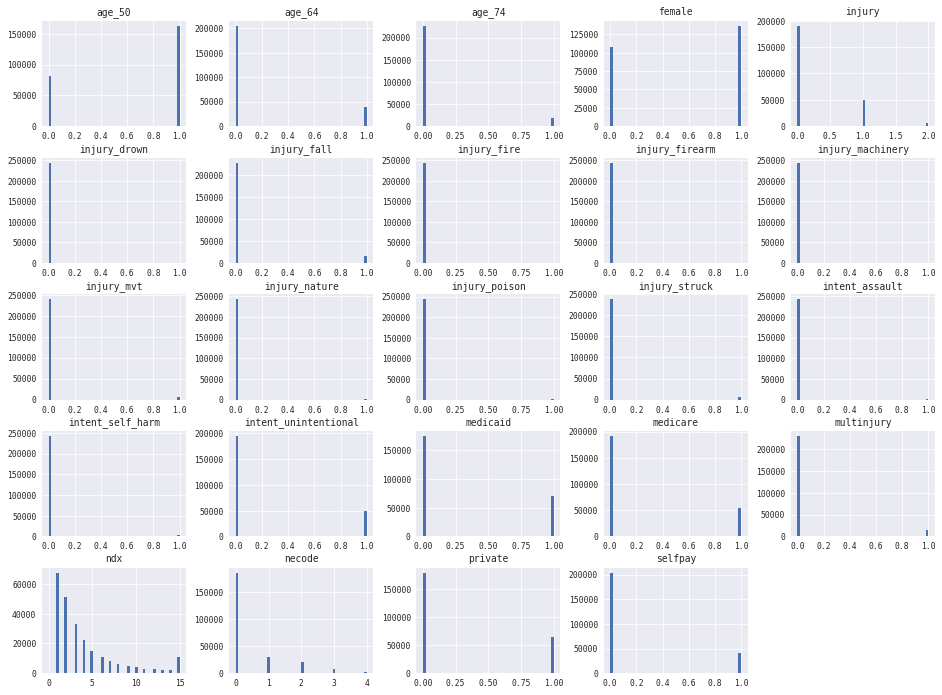

In [41]:
## plot the histogram
neds[features].hist(figsize=(16,12),bins=50)
plt.show()

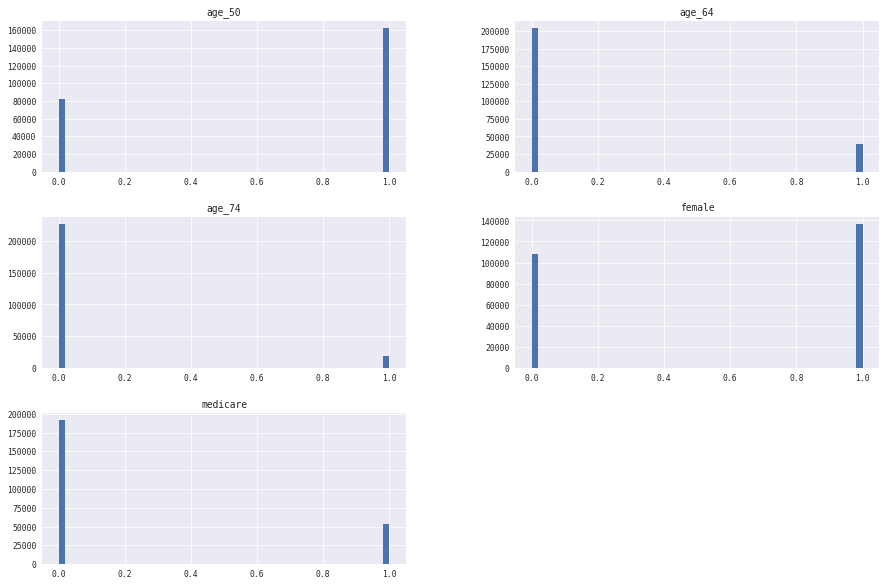

In [42]:
## summarize a dataset (histogram, boxplot, mean, mode, median, std/variance, quantile)
neds[features].ix[:,:5].hist(figsize=(15,10),bins=50)
plt.show()

In [44]:
X = neds[features]
Y = neds[target]

#split the data
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size = 0.1, random_state= 1)

In [45]:
# imputation
def imp (XTrain, YTrain, XTest, YTest):
    imp = Imputer(missing_values='NaN', strategy="mean")
    XTrain_Imp = imp.fit_transform(XTrain)
    YTrain_Imp = imp.fit_transform(YTrain.reshape(-1, 1)).ravel().astype(int)   
    XTest_Imp = imp.fit_transform(XTest)
    YTest_Imp = imp.fit_transform(YTest.reshape(-1, 1)).ravel().astype(int)    
    return XTrain_Imp , YTrain_Imp, XTest_Imp, YTest_Imp

XTrain_Imp , YTrain_Imp, XTest_Imp, YTest_Imp = imp(XTrain, YTrain, XTest, YTest) 

C:\Users\binh\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\binh\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [46]:
ed_linear = LinearRegression()
ed_linear.fit(XTrain_Imp, YTrain_Imp)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
# k-fold validation
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score 

seed=10
kfold = KFold(20, n_folds = 10)
model = LinearRegression()
scores = cross_validation.cross_val_score(model, XTrain_Imp, YTrain_Imp, cv= 5, scoring = 'r2')

print("Accuracy KFold: {} (+/- {})".format(scores.mean(), scores.std()*2))
print ('Accuracy score, Test data: {}'.format(ed_linear.score(XTest_Imp, YTest_Imp)))
print ('Accuracy score, Train data: {}'.format(ed_linear.score(XTrain_Imp, YTrain_Imp)))

Accuracy KFold: 0.054191636900632736 (+/- 0.0028802180253174607)
Accuracy score, Test data: 0.05011827669556457
Accuracy score, Train data: 0.05453665741277314


In [48]:
Y_pred = ed_linear.predict(XTest_Imp)
Y_pred_train = ed_linear.predict(XTrain_Imp)

from sklearn.metrics import r2_score

def model_accuracy (model, y_test, y_train, y_predict, y_predict_train):
    train_score = r2_score(y_test, y_predict)
    print('Train data R2: %s' %train_score)    ### R2 is equal score
    test_score = r2_score(y_train, y_predict_train)
    print('Test data R2: %s' %test_score) 
    return train_score, test_score
  
model_accuracy (ed_linear, YTest_Imp, YTrain_Imp, Y_pred, Y_pred_train)

Train data R2: 0.0501182766956
Test data R2: 0.0545366574128


(0.050118276695564568, 0.054536657412773137)

In [98]:
## define print coefficient function
def print_coef (model, XTest):
    export = pd.DataFrame()
    export['features'] = XTest.columns.values
    export['coef'] = model.coef_.flatten()
    print (export)
    print('Intercept: %s' %model.intercept_)
    return

print_coef(ed_linear, XTest)

                features         coef
0                 age_50  -461.726659
1                 age_64   -19.106593
2                 age_74    39.989352
3                 female   143.297311
4               medicare    60.661715
5               medicaid  -346.233273
6                private   183.653114
7                selfpay    -2.434499
8                 injury   -67.174504
9             multinjury   686.286919
10                   ndx    60.323380
11                necode  -150.007627
12      intent_self_harm   306.137864
13  intent_unintentional  -373.792398
14        intent_assault   632.305977
15          injury_drown  1159.295825
16           injury_fall   593.864152
17           injury_fire  -663.593593
18        injury_firearm  1419.431820
19      injury_machinery    67.963521
20            injury_mvt   829.875563
21         injury_nature  -385.301769
22         injury_poison   502.369214
23         injury_struck    47.468673
Intercept: 2405.04986611


### k-means

In [57]:
## cross-tab between total ED charges and types of ED discharges
cols = ['age', 'totchg_ed', 'medicare','ed_group','age_group']
neds[cols].groupby('ed_group').count()

,age,totchg_ed,medicare,age_group
ed_group,,,,
1.0,204868,204873,204873,204868
2.0,6858,6858,6858,6858
3.0,32190,32191,32191,32190
4.0,360,360,360,360


In [59]:
neds[cols].groupby(['ed_group', 'age_group']).size()

ed_group  age_group
1.0       1.0          46017
          2.0          76656
          3.0          57893
          4.0          24302
2.0       1.0            953
          2.0           1369
          3.0           1977
          4.0           2559
3.0       1.0           1484
          2.0           4727
          3.0          10998
          4.0          14981
4.0       1.0             16
          2.0             30
          3.0            123
          4.0            191
dtype: int64

In [76]:
from sklearn.cluster import KMeans
ed_km = KMeans(n_clusters=20)
ed_km.fit(XTrain_Imp, YTrain_Imp)
y_pred = ed_km.fit_predict(XTest_Imp)
y_pred_train = ed_km.fit_predict(XTrain_Imp)

In [77]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print('Kmean model RMSE: {}'.format(np.sqrt(mean_squared_error(YTest_Imp, y_pred))))
print('Kmean model R2 - test data: {}'.format(r2_score(YTest_Imp, y_pred)))
print('Kmean model R2 - train data: {}'.format(r2_score(YTrain_Imp, y_pred_train)))
print('Kmean accuracy score - test data: {}'.format(ed_km.score(XTest_Imp,  YTest_Imp)))

'''the KMeans model fits the data badly....'''

Kmean model RMSE: 3342.0086084511468
Kmean model R2 - test data: -0.9021748377317007
Kmean model R2 - train data: -0.8975329619035026
Kmean accuracy score - test data: -38605.27638293576


'the KMeans model fits the data badly....'

### Lasso and gridsearch

In [99]:
from sklearn import linear_model
ed_lasso = linear_model.Lasso(alpha = 0.01)
ed_lasso.fit(XTrain_Imp, YTrain_Imp)
print_coef(ed_lasso, XTest)

                features         coef
0                 age_50  -461.533046
1                 age_64   -18.888284
2                 age_74    39.964767
3                 female   143.238064
4               medicare    60.693332
5               medicaid  -346.215835
6                private   183.617651
7                selfpay    -2.370817
8                 injury   -66.967993
9             multinjury   686.312240
10                   ndx    60.333945
11                necode  -149.898051
12      intent_self_harm   305.349497
13  intent_unintentional  -373.595888
14        intent_assault   631.724737
15          injury_drown  1074.001882
16           injury_fall   593.133866
17           injury_fire  -660.759343
18        injury_firearm  1395.267388
19      injury_machinery    55.572633
20            injury_mvt   828.904705
21         injury_nature  -384.994311
22         injury_poison   500.607750
23         injury_struck    46.652000
Intercept: 2404.86744196


In [100]:
## optimize Lasso 
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
alphas = np.logspace(-5, 2, 30, endpoint=True, base=10.0, dtype=None)
lasso_grid = GridSearchCV(estimator=Lasso(), param_grid = dict(alpha=alphas), cv=10, scoring='r2')
lasso_grid.fit(XTrain_Imp, YTrain_Imp) 

print ('Lasso best parameters %s' %lasso_grid.best_params_)
print ('Lasso best scores %s'  %lasso_grid.best_score_ ) 

for params, mean_score, scores in lasso_grid.grid_scores_:
    print (mean_score, params)    
    
## Lasso regression - l1 - variable shrinkages
from sklearn import linear_model
ed_cost_lasso = linear_model.Ridge(alpha=0.072789538439831533)
ed_cost_lasso.fit(XTrain_Imp, YTrain_Imp)

print_coef(ed_cost_lasso, XTest)

Lasso best parameters {'alpha': 0.12689610031679235}
Lasso best scores 0.054226787562
0.0542126532748 {'alpha': 1.0000000000000001e-05}
0.054212653573 {'alpha': 1.7433288221999873e-05}
0.0542126540916 {'alpha': 3.0391953823131949e-05}
0.0542126549948 {'alpha': 5.2983169062837125e-05}
0.0542126565625 {'alpha': 9.2367085718738658e-05}
0.0542126592717 {'alpha': 0.00016102620275609391}
0.0542126639652 {'alpha': 0.00028072162039411759}
0.0542126719631 {'alpha': 0.00048939009184774938}
0.0542126854804 {'alpha': 0.00085316785241728145}
0.0542127074604 {'alpha': 0.0014873521072935117}
0.0542127411484 {'alpha': 0.0025929437974046669}
0.0542127858622 {'alpha': 0.0045203536563602452}
0.0542128219628 {'alpha': 0.0078804628156699131}
0.0542127591242 {'alpha': 0.013738237958832637}
0.0542124031813 {'alpha': 0.023950266199874861}
0.0542174415211 {'alpha': 0.041753189365604043}
0.0542240035343 {'alpha': 0.072789538439831533}
0.054226787562 {'alpha': 0.12689610031679235}
0.0542186471423 {'alpha': 0.221

C:\Users\binh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [101]:
## optimize Ridge
from sklearn.linear_model import Ridge
alphas = np.logspace(-5, 2, 30, endpoint = True, base = 10.0, dtype = None)
ridge_grid = GridSearchCV(estimator = Ridge(), param_grid = dict(alpha = alphas), cv =10, scoring = 'r2')
ridge_grid.fit(XTrain_Imp, YTrain_Imp)

print ('Ridge best parameters %s' %ridge_grid.best_params_)
print ('Ridge best scores %s'  %ridge_grid.best_score_ ) 

for params, mean_score, scores in ridge_grid.grid_scores_:
    print(mean_score, params)
    
tot_exp_ridge = linear_model.Ridge(alpha=0.01)
tot_exp_ridge.fit(XTrain_Imp, YTrain_Imp)

print_coef(tot_exp_ridge, XTest)

Ridge best parameters {'alpha': 18.873918221350994}
Ridge best scores 0.0542303239612
0.0542126529007 {'alpha': 1.0000000000000001e-05}
0.0542126529207 {'alpha': 1.7433288221999873e-05}
0.0542126529556 {'alpha': 3.0391953823131949e-05}
0.0542126530163 {'alpha': 5.2983169062837125e-05}
0.0542126531223 {'alpha': 9.2367085718738658e-05}
0.0542126533069 {'alpha': 0.00016102620275609391}
0.0542126536289 {'alpha': 0.00028072162039411759}
0.0542126541901 {'alpha': 0.00048939009184774938}
0.0542126551685 {'alpha': 0.00085316785241728145}
0.054212656874 {'alpha': 0.0014873521072935117}
0.054212659847 {'alpha': 0.0025929437974046669}
0.0542126650286 {'alpha': 0.0045203536563602452}
0.0542126740586 {'alpha': 0.0078804628156699131}
0.0542126897905 {'alpha': 0.013738237958832637}
0.054212717185 {'alpha': 0.023950266199874861}
0.0542127648476 {'alpha': 0.041753189365604043}
0.0542128476512 {'alpha': 0.072789538439831533}
0.0542129911352 {'alpha': 0.12689610031679235}
0.0542132386571 {'alpha': 0.2212

C:\Users\binh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [102]:
### Boosting model/XGBoost
from sklearn.ensemble import GradientBoostingRegressor

ed_boost = GradientBoostingRegressor()
ed_boost.fit(XTrain_Imp, YTrain_Imp)

ed_boost_pred = ed_boost.predict(XTest_Imp)
ed_boost_pred_train = ed_boost.predict(XTrain_Imp)

In [103]:
# mean squared errors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('Linear model RMSE: {}'.format(np.sqrt(mean_squared_error(YTest_Imp, ed_boost_pred))))
print('Boosted model R2 - test data: {}'.format(r2_score(YTest_Imp, ed_boost_pred)))

Linear model RMSE: 2331.6461030297623
Boosted model R2 - test data: 0.07410748794929312


In [104]:
### create a dataframe
ed_cost = pd.DataFrame()
ed_cost['score'] = ed_boost_pred
ed_cost['real_ed_cost'] = YTest_Imp

ed_cost.head(n=10)

,score,real_ed_cost
0,3303.346533,9856
1,1608.328837,3430
2,3315.007879,828
3,1608.328837,1176
4,1721.095196,812
5,3276.024463,1910
6,1525.206214,792
7,2564.238128,2020
8,2956.683522,875
9,3354.825788,764


In [105]:
## random forest 
from sklearn.ensemble import RandomForestRegressor
ed_rf = RandomForestRegressor().fit(XTrain_Imp, YTrain_Imp)

rf_pred = ed_rf.predict(XTest_Imp)
rf_pred_train = ed_rf.predict(XTrain_Imp)

In [106]:
print("Random forest  RMSE: {}".format(np.sqrt(mean_squared_error(YTest_Imp, rf_pred))))
print("Random forest R2 - test data: {}".format(r2_score(YTest_Imp, rf_pred)))
print("Random forest R2 - train data : {}".format(r2_score(YTrain_Imp, rf_pred_train)))

Random forest  RMSE: 2384.32120634953
Random forest R2 - test data: 0.03180056046644408
Random forest R2 - train data : 0.13481711407028674


In [ ]:
### pipeline with gradientboostingregressor and randomforestregressor
grd = GradientBoostingRegressor()
grd_enc = OneHotEncoder()
grd_lm = RandomForestRegressor()
grd.fit(XTrain_Imp, YTrain_Imp)
grd_enc.fit(grd.apply(XTrain_Imp))
grd_lm.fit(grd_enc.transform(grd.apply(XTrain_Imp)), YTrain_Imp)

y_pred_grd_lm = grd_lm.predict(
    grd_enc.transform(grd.apply(XTest_Imp)))[:, 1]

In [ ]:
### pipeline with standard scaller == not working
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(rf_pred, ed_boost)

pipeline.fit(XTrain_Imp, YTrain_Imp)

In [110]:
## XGBoost

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': [3,5], 'min_child_weight' : [2,4]}
ind_params = {'learning_rate': 0.5 , 'n_estimators': 1000, 'seed':0 ,
             'subsample': 0.8,}

xgb_edcost = GridSearchCV(xgb.XGBRegressor(**ind_params),
                         cv_params,
                         scoring = 'r2', cv = 5, n_jobs = -1)

xgb_edcost.fit(XTrain_Imp, YTrain_Imp)
xgb_edcost.grid_scores_

print('Best ED cost score: {}'.format(xgb_edcost.best_score_))
print('Best ED parameters: %s' %xgb_edcost.best_params)

Best ED cost score: 0.07402261475912464


C:\Users\binh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


AttributeError: 'GridSearchCV' object has no attribute 'best_params'

In [ ]:
xgb_pred = xgb_edcost.predict(XTest_Imp)
xgb_pred_train = xgb_edcost.predict(XTrain_Imp)

## model accuracy
